# GRU Implementation (Separate Model from GP)

In [1]:
import pandas as pd 
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, models

## GRU Preprocessing

In [4]:
# Load the training data
df = pd.read_csv("../data/train.csv")
print(df.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker


First, preprocess the raw data by encoding the categorical columns (Sex, SmokingStatus) into numerical since GRU is a neural network the only accepts numerical. Then, scale columns (Weeks, FVC) to make sure their large scaled numbers do not overpower other columns. 

In [5]:
df['Sex_id'] = df['Sex'].map({'Male': 0, 'Female': 1})
df['Smk_id'] = df['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 1, 'Currently smokes': 2})

ids = df['Patient'].unique()
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=3244)

train_df = df[df['Patient'].isin(train_ids)].reset_index(drop=True)
val_df   = df[df['Patient'].isin(val_ids)].reset_index(drop=True)

# Scale columns "Weeks" and "FVC"
time_scaler = StandardScaler()
fvc_scaler = StandardScaler()
train_df["Weeks_scaled"] = time_scaler.fit_transform(train_df[["Weeks"]])
train_df["FVC_scaled"] = fvc_scaler.fit_transform(train_df[["FVC"]])
val_df["Weeks_scaled"] = time_scaler.transform(val_df[["Weeks"]])
val_df["FVC_scaled"] = fvc_scaler.transform(val_df[["FVC"]])

# Calculate baseline FVC (scaled)
baseline_fvc_tr = train_df.groupby('Patient')['FVC_scaled'].first().to_dict()
baseline_fvc_val = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
train_df['Baseline_FVC'] = train_df['Patient'].map(baseline_fvc_tr)
val_df['Baseline_FVC'] = val_df['Patient'].map(baseline_fvc_val)

# Sort by patient and weeks
train_df = train_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)
val_df = val_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)

# print(val_df.head())
# print(train_df.head())


## Input Transformation for GRU

Next step is to ensure that our data is transformed to become inputs for GRU. GRU accepts time sequence data, which needs to have constatnt number of features but may have differing time sequence lengths. Since, each patient has differing length of weeks, it is an advantage to use GRU. Thus, we build per-patient sequences, which has a shape of : (num_patients, T_max, num_features).

In [6]:
# Build per-patient sequences
patients_tr = train_df['Patient'].unique()
patients_val = val_df['Patient'].unique()
print(f"Number of patients in training set: {len(patients_tr)}")
print(f"Number of patients in validation set: {len(patients_val)}")

list_X_tr = [] # each element has the shape (T_i, num_features)
list_y_tr = [] # each element has the shape (T_i, 1)
list_X_val = [] # each element has the shape (T_i, num_features)
list_y_val = [] # each element has the shape (T_i, 1)
feature_cols = ["Weeks_scaled", "Age", "Sex_id","Smk_id", "Baseline_FVC"]

for pid in patients_tr:
    sub = train_df[train_df['Patient'] == pid].sort_values('Weeks')

    # feature for ith element : (T_i, num_features)
    X_i = sub[feature_cols].values.astype("float32")
    # print(f"patient {pid} :\n", X_i) # to check the shape of the input

    # target for the ith element : FVC (T_i, 1 )
    y_i = sub[['FVC_scaled']].values.astype("float32").reshape(-1, 1)
    # print(f"patient {pid} target:\n", y_i) # to check the shape of the target

    list_X_tr.append(X_i)
    list_y_tr.append(y_i)

for pid in patients_val:
    sub = val_df[val_df['Patient'] == pid].sort_values('Weeks')
    
    # feature for ith element : (T_i, num_features)
    X_i = sub[feature_cols].values.astype("float32")
    print(f"patient {pid} :\n", X_i) # to check the shape of the input


    # target for the ith element : FVC (T_i, 1 )
    y_i = sub[['FVC_scaled']].values.astype("float32").reshape(-1, 1)
    print(f"patient {pid} target:\n", y_i) # to check the shape of the target

    list_X_val.append(X_i)
    list_y_val.append(y_i)



Number of patients in training set: 140
Number of patients in validation set: 36
patient ID00020637202178344345685 :
 [[-5.6249803e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-5.1941425e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-4.3324673e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-3.4707919e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-2.6091164e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-2.4090598e-03  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [ 5.5767989e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [ 9.8851758e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [ 1.6778579e+00  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]]
patient ID00020637202178344345685 target:
 [[-0.46920308]
 [-0.6472438 ]
 [-0.53011173]
 [-0.52425516]
 [-0.7046385 ]
 [-0.6823834 ]
 [-0.74914867]
 [-0.8873645 

The T_max numbers for train and validation doesn't have to match each other. 

In [7]:
X_tr = pad_sequences(list_X_tr, padding = "post", dtype = "float32", value = 0.0)
y_tr = pad_sequences(list_y_tr, padding = "post", dtype = "float32", value = 0.0)

X_val = pad_sequences(list_X_val, padding = "post", dtype = "float32", value = 0.0)
y_val = pad_sequences(list_y_val, padding = "post", dtype = "float32", value = 0.0)

print("X_tr shape:", X_tr.shape)  # (N, T_max, num_features)
print("y_tr shape:", y_tr.shape)  # (N, T_max, 1)

print("X_val shape:", X_val.shape)  # (N, T_max, num_features)
print("y_val shape:", y_val.shape)  # (N, T_max,

X_tr shape: (140, 10, 5)
y_tr shape: (140, 10, 1)
X_val shape: (36, 9, 5)
y_val shape: (36, 9, 1)


## GRU Model

In [9]:
num_features = X_tr.shape[-1]
print("Number of features:", num_features)

inputs = layers.Input(shape=(None, num_features))  # (batch, T, F)
x = layers.Masking(mask_value=0.0)(inputs)

x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)

# output mean FVC per timestep
mu = layers.TimeDistributed(layers.Dense(1), name="fvc_mean")(x)

model = models.Model(inputs, mu)
model.compile(optimizer="adam", loss="mae")

model.summary()

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )
    ]
)


Number of features: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 5)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, None, 5)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, None, 64)  │     13,632 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, None, 32)  │      9,408 │ gru[0][0],        │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fvc_mean            │ (None, None, 1)   │         33 │ gru_1[0][0],      │
│ (TimeDistributed)   │                   │            │ any[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,073 (90.13 KB)

 Trainable params: 23,073 (90.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.8159 - val_loss: 0.7148
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8272 - val_loss: 0.7141
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7812 - val_loss: 0.6768
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7672 - val_loss: 0.6519
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6765 - val_loss: 0.5833
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6520 - val_loss: 0.4835
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5210 - val_loss: 0.3610
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4117 - val_loss: 0.4068
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3649 - val_loss: 0.3056
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3270 - val_loss: 0.2662
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2938 - val_loss: 0.3144
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2927 - val_loss: 0.2674
Epoch 13/50


In [10]:
import tensorflow as tf

def osic_laplace_loss(y_true, y_pred):
    """
    y_true: (batch, T, 1)  -> true FVC (in mL or z-score)
    y_pred: (batch, T, 2)  -> [mu, log_sigma]
    """
    mu       = y_pred[..., 0]
    log_sigma = y_pred[..., 1]

    # make sigma positive
    sigma = tf.nn.softplus(log_sigma) + 1e-6

    # optional: clip as in OSIC (min 70 mL)
    sigma_clipped = tf.maximum(sigma, 70.0)

    # absolute error
    diff = tf.abs(y_true[..., 0] - mu)

    # Laplace log-likelihood (sign flipped for minimization)
    # competition score ~ mean( -log(2σ) - sqrt(2)* diff / σ )
    # here we just use a simplified version:
    loss = tf.math.log(2.0 * sigma_clipped) + diff / sigma_clipped

    # Mask out padded timesteps (assuming padded y_true are 0 and REAL FVC never 0)
    mask = tf.cast(tf.not_equal(y_true[..., 0], 0.0), tf.float32)
    loss = loss * mask

    # avoid division by zero in averaging
    denom = tf.reduce_sum(mask) + 1e-6
    return tf.reduce_sum(loss) / denom


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=osic_laplace_loss
)

In [12]:
i = 0  # first patient in validation set
x_sample = X_val[i:i+1]         # shape (1, T_val_i, num_features)
y_pred = model.predict(x_sample)

print("Predicted FVC mean shape:", y_pred.shape)  # (1, T_val_i, 1)
print(y_pred[0])   # remove batch dimension


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted FVC mean shape: (1, 9, 1)
[[-0.63394165]
 [-0.5884699 ]
 [-0.5908034 ]
 [-0.6132567 ]
 [-0.646431  ]
 [-0.680841  ]
 [-0.7152463 ]
 [-0.73930734]
 [-0.76336694]]


## GRU Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


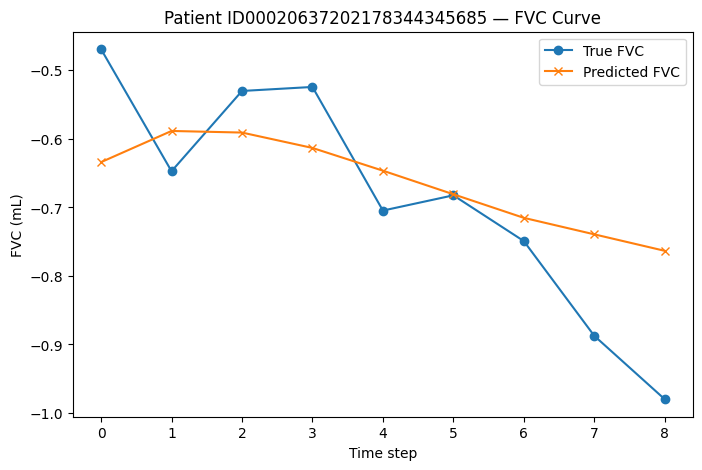

In [13]:
import matplotlib.pyplot as plt
import numpy as np

i = 0  # pick a patient
x_sample = X_val[i:i+1]
y_true = y_val[i]
y_pred = model.predict(x_sample)[0]  # remove batch dimension

# mask padded zeros
mask = y_true[:,0] != 0  

plt.figure(figsize=(8,5))
plt.plot(y_true[mask,0], label="True FVC", marker='o')
plt.plot(y_pred[mask,0], label="Predicted FVC", marker='x')
plt.title(f"Patient {patients_val[i]} — FVC Curve")
plt.xlabel("Time step")
plt.ylabel("FVC (mL)")
plt.legend()
plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_n_patients(model, X_val, y_val, patients_val, feature_cols, n=5):
    """
    Plots True FVC, GRU-predicted FVC, and optional GP mean (if in feature_cols)
    for the first n patients in the validation set.
    """
    n_patients = min(n, X_val.shape[0])

    # check if gp_mean and Weeks exist in features
    has_gp = "gp_mean" in feature_cols
    gp_idx = feature_cols.index("gp_mean") if has_gp else None

    has_weeks = "Weeks" in feature_cols
    weeks_idx = feature_cols.index("Weeks") if has_weeks else None

    # get predictions for those n patients
    y_val_pred = model.predict(X_val[:n_patients])

    for i in range(n_patients):
        x_seq = X_val[i]                # (T_max, num_features)
        y_true_seq = y_val[i, :, 0]     # (T_max,)
        y_pred_seq = y_val_pred[i, :, 0]  # (T_max,)

        # mask out padded timesteps (assuming padded y_true == 0)
        mask = y_true_seq != 0

        if has_weeks:
            x_axis = x_seq[mask, weeks_idx]
            x_label = "Weeks"
        else:
            x_axis = np.arange(mask.sum())
            x_label = "Time step index"

        plt.figure(figsize=(7, 4))

        # GP mean if available
        if has_gp:
            gp_seq = x_seq[mask, gp_idx]
            plt.plot(x_axis, gp_seq, linestyle="--", label="GP mean")

        # True vs GRU
        plt.plot(x_axis, y_true_seq[mask], marker="o", label="True FVC")
        plt.plot(x_axis, y_pred_seq[mask], marker="x", label="GRU predicted FVC")

        plt.title(f"Patient {patients_val[i]}")
        plt.xlabel(x_label)
        plt.ylabel("FVC (mL)")
        plt.legend()
        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


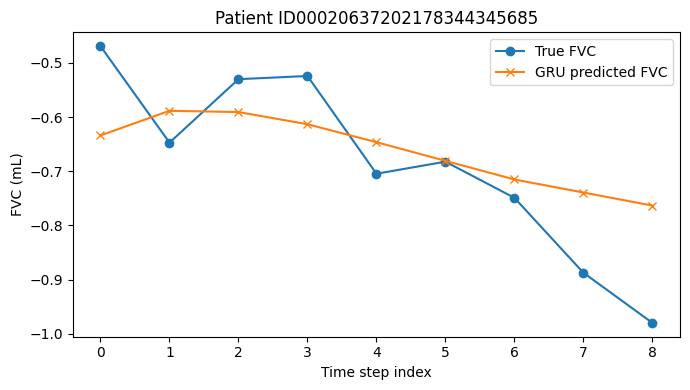

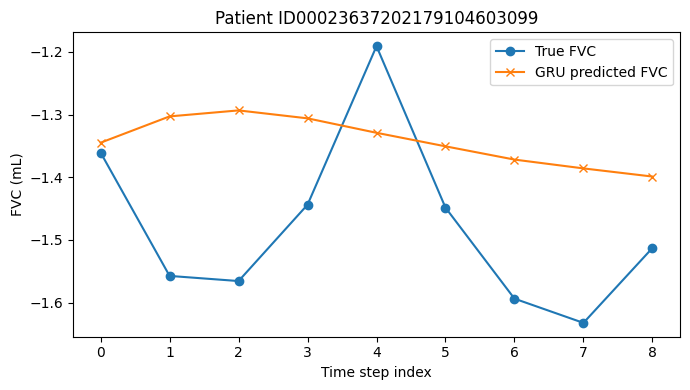

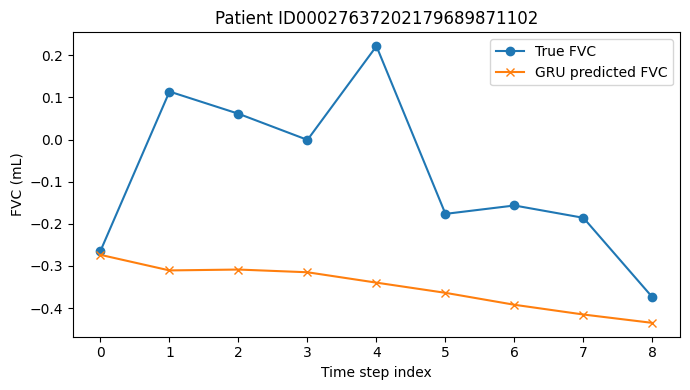

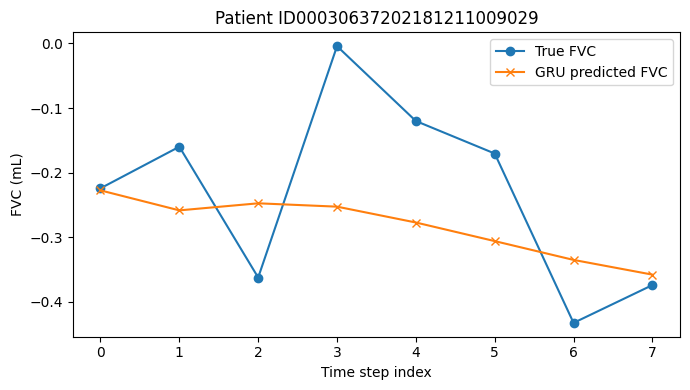

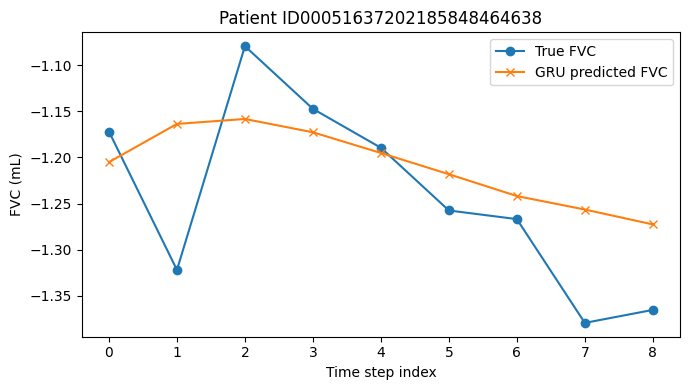

In [15]:
plot_n_patients(model, X_val, y_val, patients_val, feature_cols, n=5)